In [7]:
from tesi.database.di import get_session_maker
from tesi.zappai.di import (
    get_cds_api,
    get_crop_repository,
    get_crop_yield_data_repository,
    get_crop_yield_model_repository,
    get_location_repository,
    get_past_climate_data_repository,
)
from tesi.zappai.exceptions import CropNotFoundError

session_maker = get_session_maker()
location_repository = get_location_repository(session_maker=session_maker)
crop_repository = get_crop_repository(session_maker=session_maker)
cds_api = get_cds_api()
past_climate_data_repository = get_past_climate_data_repository(
    session_maker=session_maker,
    cds_api=cds_api,
    location_repository=location_repository,
)
crop_yield_data_repository = get_crop_yield_data_repository(
    session_maker=session_maker,
    crop_repository=crop_repository,
    location_repository=location_repository,
    past_climate_data_repository=past_climate_data_repository,
)
crop_yield_model_repository = get_crop_yield_model_repository(
    past_climate_data_repository=past_climate_data_repository,
    location_repository=location_repository,
    crop_yield_data_repository=crop_yield_data_repository,
    crop_repository=crop_repository,
)

crop = await crop_repository.get_crop_by_name("maize")
if crop is None:
    raise CropNotFoundError(f'crop with name "maize" not found')
model, mse, r2, x_train, x_test, y_train, y_test = (
    await crop_yield_model_repository.create_crop_yield_model(crop.id)
)

In [8]:
from sklearn.metrics import mean_squared_error, r2_score

y_pred = model.predict(x_test.to_numpy())
mse = mean_squared_error(y_true=y_test, y_pred=y_pred)
r2 = r2_score(y_true=y_test, y_pred=y_pred)

print(f"r2: {r2}")
print(f"mse: {mse}")

r2: 0.44037983254864643
mse: 5990318.900930756


<Axes: >

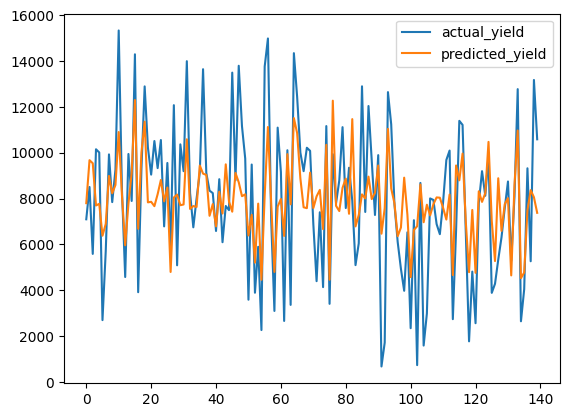

In [9]:
result_df = x_test.copy()
result_df = result_df.reset_index(drop=True)
result_df["actual_yield"] = y_test.to_numpy()
result_df["predicted_yield"] = y_pred
result_df[["actual_yield", "predicted_yield"]].plot()